Quantum Variational Rewinding
=============================

*Authors: Jack Stephen Baker, Santosh Kumar Radha*

*Revised by: Ara G.*

✅ This notebook is based on our QVR demo for Pennylane: [Quantum detection of time series anomalies](https://pennylane.ai/qml/demos/tutorial_univariate_qvr)


---

What is a time series?
======================

A general time series $\boldsymbol{y}$ can be described as a sequence of
$p$-many observations of a process/system arranged in chronological
order:

$$\boldsymbol{y} := (\boldsymbol{y}_t: t \in T), \quad T := (t_l: l \in \mathbb{Z}^{+}_{\leq p}).$$

## Anomaly detection
The goal of time series anomaly detection is to determine a suitable *anomaly
score* $a_{X}$ which is $\approx 0$ for *normal* time series $x \in X$

An *unseen* time series $y$ is then considered *anomalous* if $a_X(y) > \zeta$ for some
$\zeta \in \mathbb{R}$, $\zeta > 0$.

## Procedure
### 1. Embedding

Generate a sequence $\mathcal{S} := (|x_{t} \rangle: t \in T)$ of $n$-qubit quantum states
for each point $x_{t}$ in a classical time series.

Suppose that each $|x_t \rangle$ is a quantum state evolved
to a time $t$, as generated by an *unknown embedding Hamiltonian* $H_E$
(or an [embedding unitary]((https://docs.pennylane.ai/en/stable/introduction/templates.html#embedding-templates)) $U(x_{t})$):

$$ |x_t \rangle = U(x_t)|0\rangle^{\otimes n} = e^{-iH_E(x_t)}|0\rangle^{\otimes n} $$

### 2. Time evolution
We assume that time evolution for $|x_t\rangle$ is governed by a *parameterized* operator $e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$, such that

$$|x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma}\rangle := e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}|x_t\rangle $$

Since $e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$ is *Hermitian*, we can implement its eigendecomposition

$$V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma}) := W^{\dagger}(\boldsymbol{\alpha})D(\boldsymbol{\gamma}, t)W(\boldsymbol{\alpha}) = e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$$

where

- $W(\boldsymbol{\alpha})$ is parametrized by $\boldsymbol{\alpha}$
- $D(\boldsymbol{\gamma}, t)$ (diagonal) is parametrized by $\boldsymbol{\gamma}.$

Next, we'll proceed by choosing $W$ and $D$ (i.e. $\boldsymbol{\alpha}$ and $\boldsymbol{\gamma}$) that fit a specific condition.

### 3. Rewinding

We want to approximate an operator $V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma})$ that maps any point $|x_t\rangle$ in a *training set* time series $\boldsymbol{x}$ back to the original state $|0\rangle^{\otimes n}$. In other words, we seek $\boldsymbol{\alpha}$ and $\boldsymbol{\gamma}$ such that

$$ V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma})|x_t\rangle \approx |0\rangle^{\otimes n}. $$

Once we've done this, we'll have a transformation that produces a known outcome for *non-anomalous* time series.

> 💡 Applying $V_t(\boldsymbol{\alpha}^\star, \boldsymbol{\gamma}^\star)$ to a *new* time series $y$ will produce a different outcome, which we can use to determine whether $y$ is anomalous.

## Loss Function
We consider the average effect of many Hamiltonians generated by drawing $\boldsymbol{\gamma}$
from a normal distribution $\mathcal{N}(\mu, \sigma)$:

$$F(\boldsymbol{\phi}, x_t) := \mathop{\mathbb{E}_{\boldsymbol{\gamma} \sim \mathcal{N}(\mu, \sigma)}}\left[\langle 0|^{\otimes n} |x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma}\rangle  \right], \quad \boldsymbol{\phi} = [\boldsymbol{\alpha}, \mu, \sigma].$$

Then we define our loss function as

$$\mathcal{L(\boldsymbol{\phi})} = \frac{1}{2|X||T|}\sum_{x \in X} \sum_{t \in T}[1 - F(\boldsymbol{\phi}, x_t)]^2 + P_{\tau}(\sigma),$$

where
- $P_{\tau}(\sigma)$ is a penalty function (nothing fancy, it's just an arctan function)
- $\tau$ is a hyperparameter that controls the steepness of the penalty function

## Anomaly Score
Finally, the anomaly score that we use to classify *new* time series will have the form

$$a_X(y) = \frac{1}{|T|}\sum_{t \in T}[1 - F(\boldsymbol{\phi}^{\star}, y_t)]^2.$$

In [1]:
from itertools import combinations
import math

import covalent as ct
import matplotlib.pyplot as plt
import pennylane as qml
import torch


# Seed Torch for reproducibility and set default tensor type
GLOBAL_SEED = 1989
torch.manual_seed(GLOBAL_SEED)
torch.set_default_tensor_type(torch.DoubleTensor)

---

# Tasks for Workflow 1: Training the QVR model

### Generating a "normal" time series

In [2]:
@ct.electron
def generate_normal_time_series_set(
    p: int,
    num_series: int,
    noise_amp: float,
    t_init: float,
    t_end: float,
    seed: int = GLOBAL_SEED
) -> tuple:
    """Generate a normal time series data set where each of the p elements
    is drawn from a normal distribution x_t ~ N(0, noise_amp).
    """
    torch.manual_seed(seed)
    X = torch.normal(0, noise_amp, (num_series, p))
    T = torch.linspace(t_init, t_end, p)
    return X, T

### Gerating an "anomalous" time series

In [3]:

@ct.electron
def generate_anomalous_time_series_set(
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    seed: int = GLOBAL_SEED,
) -> tuple:
    """Generate an anomalous time series data set where the p elements of each sequence are
    from a normal distribution x_t ~ N(0, noise_amp). Then,
    anomalous spikes of random amplitudes and durations are inserted.
    """
    torch.manual_seed(seed)
    Y = torch.normal(0, noise_amp, (num_series, p))
    for y in Y:
        # 5–10 spikes allowed
        spike_num = torch.randint(low=5, high=10, size=())
        durations = torch.randint(low=1, high=max_duration, size=(spike_num,))
        spike_start_idxs = torch.randperm(p - max_duration)[:spike_num]
        for start_idx, duration in zip(spike_start_idxs, durations):
            y[start_idx : start_idx + duration] += torch.normal(0.0, spike_amp, (duration,))
    T = torch.linspace(t_init, t_end, p)
    return Y, T

### Visualize Normal vs. Anomalous Time Series

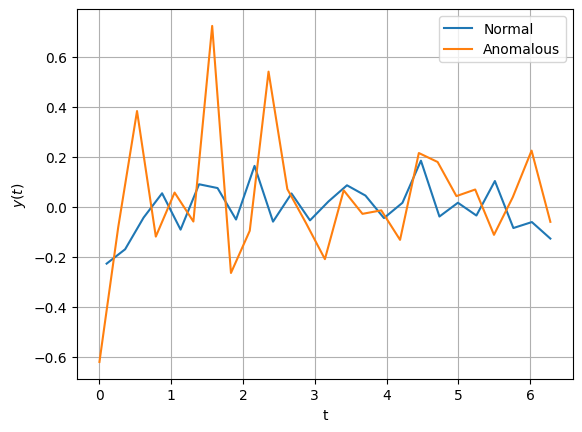

In [4]:
X_norm, T_norm = generate_normal_time_series_set(25, 25, 0.1, 0.1, 2 * torch.pi)
Y_anom, T_anom = generate_anomalous_time_series_set(25, 25, 0.1, 0.4, 5, 0, 2 * torch.pi)

plt.figure()
plt.plot(T_norm, X_norm[0], label="Normal")
plt.plot(T_anom, Y_anom[1], label="Anomalous")
plt.ylabel("$y(t)$")
plt.xlabel("t")
plt.grid()
leg = plt.legend()

### Data transformation and feeding


In [5]:
from collections.abc import Iterator


class DataGetter:
    """A pickleable mock-up of a Python iterator on a torch.utils.Dataloader.
    Provide a dataset X and the resulting object O will allow you to use next(O).
    """

    def __init__(self, X: torch.Tensor, batch_size: int, seed: int = GLOBAL_SEED) -> None:
        """Calls the _init_data method on intialization of a DataGetter object."""
        torch.manual_seed(seed)
        self.X = X
        self.batch_size = batch_size
        self.data = []
        self._init_data(
            iter(torch.utils.data.DataLoader(self.X, batch_size=self.batch_size, shuffle=True))
        )

    def _init_data(self, iterator: Iterator) -> None:
        """Load all of the iterator into a list."""
        x = next(iterator, None)
        while x is not None:
            self.data.append(x)
            x = next(iterator, None)

    def __next__(self) -> tuple:
        """Analogous behaviour to the native Python next() but calling the
        .pop() of the data attribute.
        """
        try:
            return self.data.pop()
        except IndexError:  # Caught when the data set runs out of elements
            self._init_data(
                iter(torch.utils.data.DataLoader(self.X, batch_size=self.batch_size, shuffle=True))
            )
            return self.data.pop()


@ct.electron
def make_atomized_training_set(X: torch.Tensor, T: torch.Tensor) -> list:
    """Convert input time series data provided in a two-dimensional tensor format
    to atomized tuple chunks: (xt, t).
    """
    X_flat = torch.flatten(X)
    T_flat = T.repeat(X.size()[0])
    atomized = [(xt, t) for xt, t in zip(X_flat, T_flat)]
    return atomized


@ct.electron
def get_training_cycler(Xtr: torch.Tensor, batch_size: int, seed: int = GLOBAL_SEED) -> DataGetter:
    """Get an instance of the DataGetter class defined above, which behaves analogously to
    next(iterator) but is pickleable.
    """
    return DataGetter(Xtr, batch_size, seed)

### Building the quantum circuit

Use Pennylane to implement $V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma}) := W^{\dagger}(\boldsymbol{\alpha})D(\boldsymbol{\gamma}, t)W(\boldsymbol{\alpha})$
by taking
- $W(\boldsymbol{\alpha})$ as [Pennylane template](https://docs.pennylane.ai/en/stable/introduction/templates.html)
- $D(\boldsymbol{\gamma}, t)$ as defined below.

In [6]:
def D(gamma_t: torch.Tensor, n_qubits: int, k: int = None, get_probs: bool = False) -> None:
    """Generates an n_qubit quantum circuit according to a k-local Walsh operator
    expansion. Here, k-local means that 1 <= k <= n of the n qubits can interact.
    See <https://doi.org/10.1088/1367-2630/16/3/033040> for more
    details. Optionally return probabilities of bit strings.
    """
    if k is None:
        k = n_qubits
    cnt = 0
    for i in range(1, k + 1):
        for comb in combinations(range(n_qubits), i):
            if len(comb) == 1:
                qml.RZ(gamma_t[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma_t[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(n_qubits))


@ct.electron
def get_callable_projector_func(k, U, W, D, n_qubits):

    # ibm_qexec = ct.executor.QiskitExecutor(
    #     backend="ibm_brisbane",
    #     device="sampler",
    #     shots=1024,
    #     ibmqx_token="<YOUR_IBMQ_TOKEN>"
    # )

    # @ct.qelectron(executor=ibm_qexec)
    @qml.qnode(qml.device("lightning.qubit", wires=n_qubits, shots=None), interface="torch")
    def quantum_circuit(
        xt: torch.Tensor,
        t: float,
        alpha: torch.Tensor,
        gamma: torch.Tensor,
        k: int,
        U: callable,
        W: callable,
        D: callable,
        n_qubits: int,
    ) -> torch.Tensor:
        """Measure the probabilities for measuring each bitstring after applying a
        circuit of the form W†DWU to the |0⟩^(⊗n) state. This
        function is defined for individual sequence elements xt.
        """
        U(xt, wires=range(n_qubits))
        W(alpha, wires=range(n_qubits))
        D(gamma * t, n_qubits, k)
        qml.adjoint(W)(alpha, wires=range(n_qubits))
        return qml.probs(range(n_qubits))

    return lambda xt, t, alpha, gamma: quantum_circuit(xt, t, alpha, gamma, k, U, W, D, n_qubits)[0]

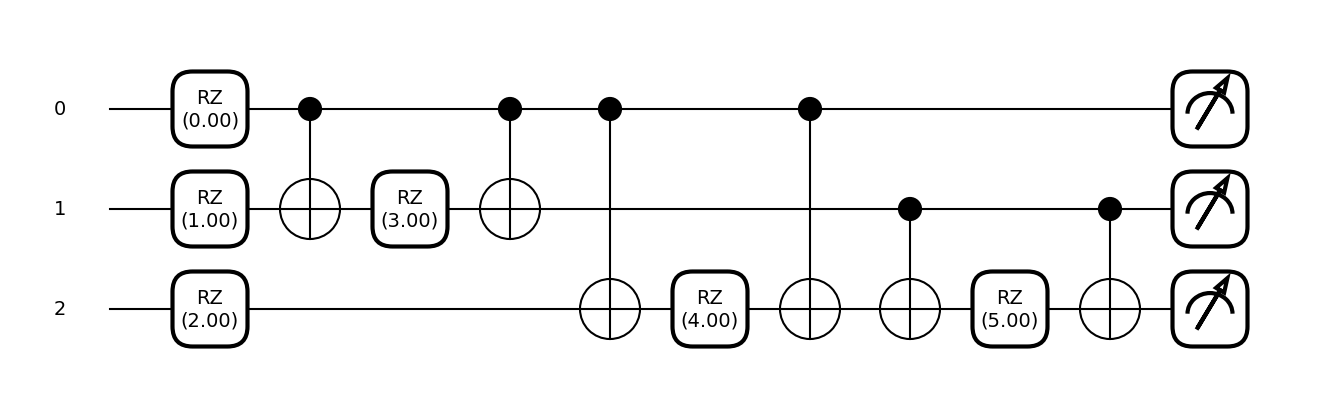

In [7]:
k_example = 2
n_qubits_example = 3

dev = qml.device("default.qubit", wires=n_qubits_example, shots=None)
D_two_qubit = qml.qnode(dev)(D)

gamma_length = sum(math.comb(n_qubits_example, i) for i in range(1, k_example + 1))
gammas = torch.arange(0, gamma_length, 1)
_ = qml.draw_mpl(D_two_qubit, decimals=2)(gammas, n_qubits_example, k_example, True)

### Building the loss function

First we implement

$$F(\boldsymbol{\phi}, x_t) := \mathop{\mathbb{E}_{\boldsymbol{\gamma} \sim \mathcal{N}(\mu, \sigma)}}\left[\langle 0|^{\otimes n} |x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma}\rangle  \right], \quad \boldsymbol{\phi} = [\boldsymbol{\alpha}, \mu, \sigma].$$

In [8]:
def F(
    callable_proj: callable,
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    n_samples: int,
    n_qubits: int,
    k: int,
) -> torch.Tensor:
    """Take the classical expectation value of of the projector on zero sampling
    the parameters of D from normal distributions. The expectation value is estimated
    with an average over n_samples.
    """
    # length of gamma should not exceed 2^n - 1
    gamma_length = sum(math.comb(n_qubits, i) for i in range(1, k + 1))
    gammas = sigma.abs() * torch.randn((n_samples, gamma_length)) + mu
    overlap_values = torch.empty(n_samples)

    for i, gamma in enumerate(gammas):
        overlap_values[i] = callable_proj(xt, t, alpha, gamma)

    return overlap_values.mean()

Then we implement the penalty function

$$P_{\tau}(\sigma) := \frac{1}{\pi} \arctan(2 \pi \tau |\sigma|).$$

In [9]:
# NOTE: only functions called directly in our lattice (workflow) need to be electrons.
@ct.electron
def callable_arctan_penalty(tau: float) -> callable:
    """Create a callable arctan function with a single hyperparameter
    tau to penalize large entries of sigma.
    """
    prefac = 1 / (torch.pi)
    callable_pen = lambda sigma: prefac * torch.arctan(2 * torch.pi * tau * sigma.abs()).mean()
    return callable_pen

Finally, the loss function

$$\mathcal{L(\boldsymbol{\phi})} = \frac{1}{2|X||T|}\sum_{x \in X} \sum_{t \in T}[1 - F(\boldsymbol{\phi}, x_t)]^2 + P_{\tau}(\sigma).$$

In [10]:
def get_loss(
    k: int,
    callable_proj: callable,
    batch: torch.Tensor,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    n_samples: int,
    n_qubits: int,
    callable_penalty: callable,
) -> torch.Tensor:
    """Evaluate the loss function ℒ, defined in the background section
    for a certain set of parameters.
    """
    X_batch, T_batch = batch
    loss = torch.empty(X_batch.size()[0])
    for i in range(X_batch.size()[0]):
        # unsqueeze required for tensor to have the correct dimension for PennyLane templates
        loss[i] = (
            1 - F(
                callable_proj,
                X_batch[i].unsqueeze(0),
                T_batch[i].unsqueeze(0),
                alpha,
                mu,
                sigma,
                n_samples,
                n_qubits,
                k,
            )
        ).square()

    return 0.5 * loss.mean() + callable_penalty(sigma)

### Training the normal model

i.e. finding the Hamiltonian that best rewinds training data to $|0\rangle^{\otimes n}$.

In [11]:
@ct.electron
def get_initial_parameters(
    W: callable, W_layers: int, n_qubits: int, seed: int = GLOBAL_SEED
) -> dict:
    """Randomly generate initial parameters. We need initial parameters for the
    variational circuit ansatz implementing W(alpha) and the standard deviation
    and mean (sigma and mu) for the normal distribution we sample gamma from.
    """
    torch.manual_seed(seed)
    init_alpha = torch.rand(W.shape(W_layers, n_qubits))
    init_mu = torch.rand(1)
    # Best to start sigma small and expand if needed
    init_sigma = torch.rand(1)
    init_params = {
        "alpha": (2 * torch.pi * init_alpha).clone().detach().requires_grad_(True),
        "mu": (2 * torch.pi * init_mu).clone().detach().requires_grad_(True),
        "sigma": (0.1 * init_sigma + 0.05).clone().detach().requires_grad_(True),
    }
    return init_params

In [12]:
from covalent.executor import AWSBatchExecutor, SlurmExecutor

DEPS_PIP = [
    "pennylane==0.32.0",
    "torch==1.13.0",
]

aws_exec = AWSBatchExecutor(
    credentials="/home/user/.aws/credentials",
    vcpu=16,
    num_gpus=1,
    memory=32,
    time_limit=7200,
)

slurm_exec = SlurmExecutor(
    username="my_user",
    address="login.cluster.org",
    ssh_key_file="/home/user/.ssh/id_rsa",
    conda_env="qml-env",
)

# @ct.electron(executor=slurm_exec, deps_pip=DEPS_PIP)
# @ct.electron(executor=aws_exec, deps_pip=DEPS_PIP)
@ct.electron
def train_model_gradients(
    k: int,
    n_qubits: int,
    lr: float,
    init_params: dict,
    pytorch_optimizer: callable,
    cycler: DataGetter,
    n_samples: int,
    callable_penalty: callable,
    batch_iterations: int,
    callable_proj: callable,
    seed=GLOBAL_SEED,
    print_intermediate=False,
) -> dict:
    """Train the QVR model (minimize the loss function) with respect to the
    variational parameters using gradient-based training. You need to pass a
    PyTorch optimizer and a learning rate (lr).
    """
    torch.device("cuda")

    torch.manual_seed(seed)
    opt = pytorch_optimizer(init_params.values(), lr=lr)
    alpha = init_params["alpha"]
    mu = init_params["mu"]
    sigma = init_params["sigma"]

    def closure():
        opt.zero_grad()
        loss = get_loss(
            k, callable_proj, next(cycler), alpha, mu, sigma, n_samples, n_qubits, callable_penalty
        )
        loss.backward()
        return loss

    loss_history = []
    for i in range(batch_iterations):
        loss = opt.step(closure)
        loss_history.append(loss.item())
        if batch_iterations % 10 == 0 and print_intermediate:
            print(f"Iteration number {i}\n Current loss {loss.item()}\n")

    results_dict = {
        "opt_params": {
            "alpha": opt.param_groups[0]["params"][0],
            "mu": opt.param_groups[0]["params"][1],
            "sigma": opt.param_groups[0]["params"][2],
        },
        "loss_history": loss_history,
    }
    return results_dict

### Workflow 1: Training Anomaly Detector


In [13]:
@ct.lattice
def training_workflow(
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    k: int,
    W_layers: int,
    n_samples: int,
    p: int,
    num_series: int,
    noise_amp: float,
    t_init: float,
    t_end: float,
    batch_size: int,
    tau: float,
    pytorch_optimizer: callable,
    lr: float,
    batch_iterations: int,
):
    """
    Combine all of the previously defined electrons to do an entire training workflow,
    including (1) generating synthetic data, (2) packaging it into training cyclers
    (3) preparing the quantum functions and (4) optimizing the loss function with
    gradient based optimization. You can find definitions for all of the arguments
    by looking at the electrons and text cells above.
    """

    X, T = generate_normal_time_series_set(p, num_series, noise_amp, t_init, t_end)
    Xtr = make_atomized_training_set(X, T)
    cycler = get_training_cycler(Xtr, batch_size)
    init_params = get_initial_parameters(W, W_layers, n_qubits)
    callable_penalty = callable_arctan_penalty(tau)
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits)
    results_dict = train_model_gradients(
        k,
        n_qubits,
        lr,
        init_params,
        pytorch_optimizer,
        cycler,
        n_samples,
        callable_penalty,
        batch_iterations,
        callable_proj,
        print_intermediate=False,
    )
    return results_dict


general_options = {
    "U": qml.AngleEmbedding,
    "W": qml.StronglyEntanglingLayers,
    "D": D,
    "n_qubits": 2,
    "n_samples": 10,
    "p": 25,
    "num_series": 25,
    "noise_amp": 0.1,
    "t_init": 0.1,
    "t_end": 2 * torch.pi,
    "k": 2,
}

training_options = {
    "batch_size": 10,
    "tau": 5,
    "pytorch_optimizer": torch.optim.Adam,
    "lr": 0.01,
    "batch_iterations": 20,  # use ~ 50 for better results
    "W_layers": 2,
}

training_options.update(general_options)

We can now dispatch the lattice to the Covalent server.


In [14]:
tr_dispatch_id = ct.dispatch(training_workflow)(**training_options)

Navigate to <http://localhost:48008/> to view the workflow on the
Covalent GUI.

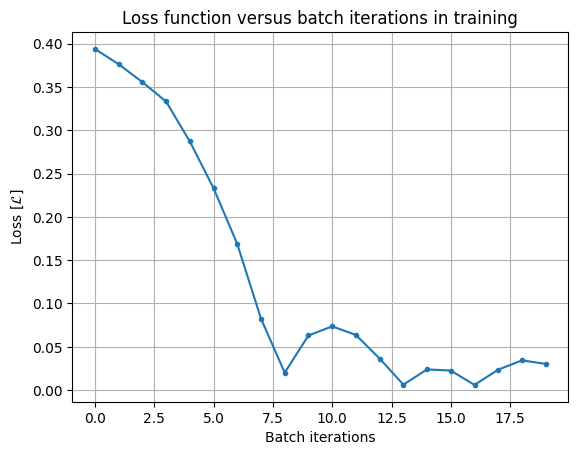

In [15]:
ct_tr_results = ct.get_result(dispatch_id=tr_dispatch_id, wait=True)
results_dict = ct_tr_results.result

plt.figure()
plt.plot(results_dict["loss_history"], ".-")
plt.ylabel("Loss [$\mathcal{L}$]")
plt.xlabel("Batch iterations")
plt.title("Loss function versus batch iterations in training")
plt.grid()

---

# Tasks for Workflow 2: Tuning the threshold $\zeta$

How anomalous is anomalous enough?

### Small utility tasks

Always run these locally.

In [16]:
@ct.electron
def get_preds_given_threshold(zeta: float, scores: torch.Tensor) -> torch.Tensor:
    """For a given threshold, get the predicted labels (1 or -1), given the anomaly scores."""
    return torch.tensor([-1 if score > zeta else 1 for score in scores])


@ct.electron
def get_truth_labels(
    normal_series_set: torch.Tensor, anomalous_series_set: torch.Tensor
) -> torch.Tensor:
    """Get a 1D tensor containing the truth values (1 or -1) for a given set of
    time series.
    """
    norm = torch.ones(normal_series_set.size()[0])
    anom = -torch.ones(anomalous_series_set.size()[0])
    return torch.cat([norm, anom])


@ct.electron
def get_accuracy_score(pred: torch.Tensor, truth: torch.Tensor) -> torch.Tensor:
    """Given the predictions and truth values, return a number between 0 and 1
    indicating the accuracy of predictions.
    """
    return torch.sum(pred == truth) / truth.size()[0]

### Brute for search for best $\zeta$

In [17]:
@ct.electron
def threshold_scan_acc_score(
    scores: torch.Tensor, truth_labels: torch.Tensor, zeta_min: float, zeta_max: float, steps: int
) -> torch.Tensor:
    """Given the anomaly scores and truth values,
    scan over a range of thresholds = [zeta_min, zeta_max] with a
    fixed number of steps, calculating the accuracy score at each point.
    """
    accs = torch.empty(steps)
    for i, zeta in enumerate(torch.linspace(zeta_min, zeta_max, steps)):
        preds = get_preds_given_threshold(zeta, scores)
        accs[i] = get_accuracy_score(preds, truth_labels)
    return accs

In [18]:
def get_anomaly_score(
    callable_proj: callable,
    y: torch.Tensor,
    T: torch.Tensor,
    alpha_star: torch.Tensor,
    mu_star: torch.Tensor,
    sigma_star: torch.Tensor,
    n_samples: int,
    n_qubits: int,
    k: int,
    get_time_resolved: bool = False,
):
    """Get the anomaly score for an input time series y. We need to pass the
    OPTIMAL parameters (arguments with suffix _star). Optionally return the
    time-resolved score (the anomaly score contribution at a given t).
    """
    scores = torch.empty(T.size()[0])
    for i in range(T.size()[0]):
        scores[i] = (
            1 - F(
                callable_proj,
                y[i].unsqueeze(0),
                T[i].unsqueeze(0),
                alpha_star,
                mu_star,
                sigma_star,
                n_samples,
                n_qubits,
                k,
            )
        ).square()
    if get_time_resolved:
        return scores, scores.mean()
    else:
        return scores.mean()


# @ct.electron(executor=slurm_exec, deps_pip=DEPS_PIP)
# @ct.electron(executor=aws_exec, deps_pip=DEPS_PIP)
@ct.electron
def get_norm_and_anom_scores(
    X_norm: torch.Tensor,
    X_anom: torch.Tensor,
    T: torch.Tensor,
    callable_proj: callable,
    model_params: dict,
    n_samples: int,
    n_qubits: int,
    k: int,
) -> torch.Tensor:
    """Get the anomaly scores assigned to input normal and anomalous time series instances.
    model_params is a dictionary containing the optimal model parameters.
    """
    torch.device("cuda")

    alpha = model_params["alpha"]
    mu = model_params["mu"]
    sigma = model_params["sigma"]
    norm_scores = torch.tensor(
        [
            get_anomaly_score(callable_proj, xt, T, alpha, mu, sigma, n_samples, n_qubits, k)
            for xt in X_norm
        ]
    )
    anom_scores = torch.tensor(
        [
            get_anomaly_score(callable_proj, xt, T, alpha, mu, sigma, n_samples, n_qubits, k)
            for xt in X_anom
        ]
    )
    return torch.cat([norm_scores, anom_scores])

### Workflow 2: Tuning the threshold $\zeta$

In [19]:
@ct.lattice
def threshold_tuning_workflow(
    opt_params: dict,
    n_samples: int,
    zeta_min: float,
    zeta_max: float,
    steps: int,
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    random_model_seeds: torch.Tensor,
    W_layers: int,
) -> tuple:
    """A workflow for tuning the threshold value zeta, in order to maximize the accuracy score
    for a validation data set. Results are tested against random models at their optimal zetas.
    """
    # Generate datasets
    X_val_norm, T = generate_normal_time_series_set(p, num_series, noise_amp, t_init, t_end)
    X_val_anom, T = generate_anomalous_time_series_set(
        p, num_series, noise_amp, spike_amp, max_duration, t_init, t_end
    )
    truth_labels = get_truth_labels(X_val_norm, X_val_anom)

    # Initialize quantum functions
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits)

    accs_list = []
    scores_list = []
    # Evaluate optimal model
    scores = get_norm_and_anom_scores(
        X_val_norm, X_val_anom, T, callable_proj, opt_params, n_samples, n_qubits, k
    )
    accs_opt = threshold_scan_acc_score(scores, truth_labels, zeta_min, zeta_max, steps)
    accs_list.append(accs_opt)
    scores_list.append(scores)

    # Evaluate random models
    for seed in random_model_seeds:
        rand_params = get_initial_parameters(W, W_layers, n_qubits, seed)
        scores = get_norm_and_anom_scores(
            X_val_norm, X_val_anom, T, callable_proj, rand_params, n_samples, n_qubits, k
        )
        accs_list.append(threshold_scan_acc_score(scores, truth_labels, zeta_min, zeta_max, steps))
        scores_list.append(scores)
    return accs_list, scores_list


threshold_tuning_options = {
    "spike_amp": 0.4,
    "max_duration": 5,
    "zeta_min": 0,
    "zeta_max": 1,
    "steps": 100000,
    "random_model_seeds": [0, 1],
    "W_layers": 2,
    "opt_params": results_dict["opt_params"],
}

threshold_tuning_options.update(general_options)

As before, we dispatch the lattice to the `Covalent` server.


In [20]:
val_dispatch_id = ct.dispatch(threshold_tuning_workflow)(**threshold_tuning_options)

Navigate to <http://localhost:48008/> to view the workflow on the
Covalent GUI.

Now, we can plot the results:


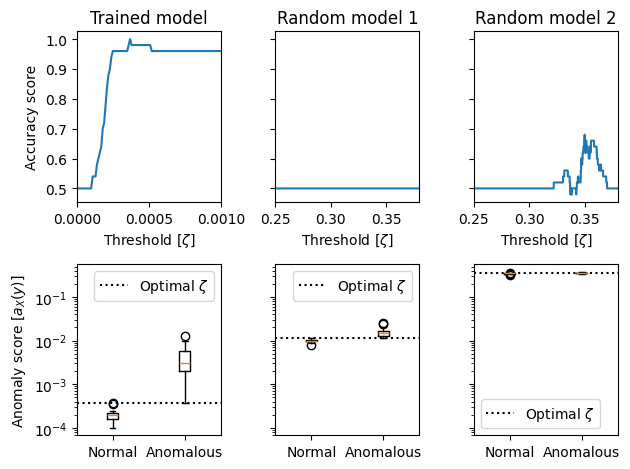

In [21]:
ct_val_results = ct.get_result(dispatch_id=val_dispatch_id, wait=True)
accs_list, scores_list = ct_val_results.result

zeta_xlims = [(0, 0.001), (0.25, 0.38), (0.25, 0.38)]
titles = ["Trained model", "Random model 1", "Random model 2"]
zetas = torch.linspace(
    threshold_tuning_options["zeta_min"],
    threshold_tuning_options["zeta_max"],
    threshold_tuning_options["steps"],
)
fig, axs = plt.subplots(ncols=3, nrows=2, sharey="row")
for i in range(3):
    axs[0, i].plot(zetas, accs_list[i])
    axs[0, i].set_xlim(zeta_xlims[i])
    axs[0, i].set_xlabel("Threshold [$\zeta$]")
    axs[0, i].set_title(titles[i])
    axs[1, i].boxplot(
        [
            scores_list[i][0 : general_options["num_series"]],
            scores_list[i][general_options["num_series"] : -1],
        ],
        labels=["Normal", "Anomalous"],
    )
    axs[1, i].set_yscale("log")
    axs[1, i].axhline(
        zetas[torch.argmax(accs_list[i])], color="k", linestyle=":", label="Optimal $\zeta$"
    )
    axs[1, i].legend()
axs[0, 0].set_ylabel("Accuracy score")
axs[1, 0].set_ylabel("Anomaly score [$a_X(y)$]")
fig.tight_layout()

We can see that the optimal model achieves high accuracy when the threshold is tuned using the validation data. On the other hand, the random models return mostly random results (sometimes even worse than random guesses), regardless of how we set the threshold.

---

Testing the model
=================

Now with optimal thresholds for our optimized and random models, we can
perform testing. We already have all of the electrons to do this, so we
create the `@ct.lattice`

In [22]:
@ct.lattice
def testing_workflow(
    opt_params: dict,
    n_samples: int,
    best_zetas: list,
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    random_model_seeds: torch.Tensor,
    W_layers: int,
) -> list:
    """A workflow for calculating anomaly scores for a set of testing time series
    given an optimal model and set of random models. We use the optimal zetas found in threshold tuning.
    """
    # Generate time series
    X_val_norm, T = generate_normal_time_series_set(p, num_series, noise_amp, t_init, t_end)
    X_val_anom, T = generate_anomalous_time_series_set(
        p, num_series, noise_amp, spike_amp, max_duration, t_init, t_end
    )
    truth_labels = get_truth_labels(X_val_norm, X_val_anom)

    # Prepare quantum functions
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits)

    accs_list = []
    # Evaluate optimal model
    scores = get_norm_and_anom_scores(
        X_val_norm, X_val_anom, T, callable_proj, opt_params, n_samples, n_qubits, k
    )
    preds = get_preds_given_threshold(best_zetas[0], scores)
    accs_list.append(get_accuracy_score(preds, truth_labels))
    # Evaluate random models
    for zeta, seed in zip(best_zetas[1:], random_model_seeds):
        rand_params = get_initial_parameters(W, W_layers, n_qubits, seed)
        scores = get_norm_and_anom_scores(
            X_val_norm, X_val_anom, T, callable_proj, rand_params, n_samples, n_qubits, k
        )
        preds = get_preds_given_threshold(zeta, scores)
        accs_list.append(get_accuracy_score(preds, truth_labels))
    return accs_list


testing_options = {
    "spike_amp": 0.4,
    "max_duration": 5,
    "best_zetas": [zetas[torch.argmax(accs)] for accs in accs_list],
    "random_model_seeds": [0, 1],
    "W_layers": 2,
    "opt_params": results_dict["opt_params"],
}

testing_options.update(general_options)

We dispatch it to the Covalent server with the appropriate parameters.


In [23]:
test_dispatch_id = ct.dispatch(testing_workflow)(**testing_options)

Navigate to <http://localhost:48008/> to view the workflow on the
Covalent GUI.

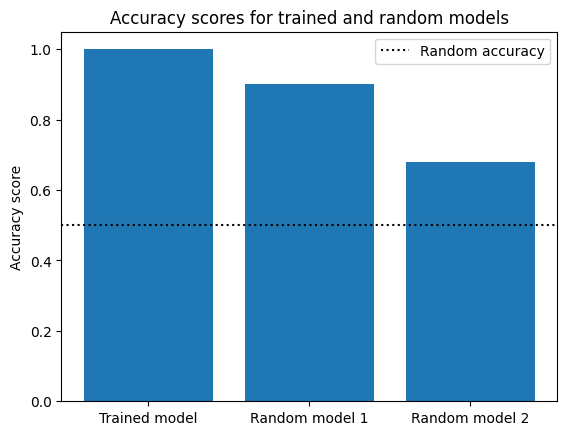

In [24]:
ct_test_results = ct.get_result(dispatch_id=test_dispatch_id, wait=True)
accs_list = ct_test_results.result

plt.figure()
plt.bar([1, 2, 3], accs_list)
plt.axhline(0.5, color="k", linestyle=":", label="Random accuracy")
plt.xticks([1, 2, 3], ["Trained model", "Random model 1", "Random model 2"])
plt.ylabel("Accuracy score")
plt.title("Accuracy scores for trained and random models")
leg = plt.legend()

As can be seen, once more, the trained model is far more accurate than
the random models. Awesome! Now that we\'re done with the calculations
in this tutorial, we just need to remember to shut down the Covalent
server


Conclusions
===========

We\'ve now reached the end of this tutorial! Quickly recounting what we
have learnt, we:

1.  Learned the background of how to detect anomalous time series
    instances, *quantumly*,
2.  Learned how to build the code to achieve this using PennyLane and
    PyTorch, and,
3.  Learned the basics of Covalent: a workflow orchestration tool for
    heterogeneous computation

If you want to learn more about QVR, you should consult the paper where
we generalize the math a little and test the algorithm on less trivial
time series data than was dealt with in this tutorial. We also ran some
experiments on real quantum computers, enhancing our results using error
mitigation techniques. If you want to play some more with Covalent,
check us out on [GitHub](https://github.com/AgnostiqHQ/covalent/) and/or
engage with other tutorials in our
[documentation](https://covalent.readthedocs.io/en/stable/).
